# Aug ??st, 2021 (play boot)

**Motivation**: SVINET <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.svinet import *
from utils.plotting import *
from utils.render import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Mice

In [41]:
svinet_props = {
    'task': 'rest',
    'mode': 'bold',
    'metric': 'pearson',
    'match_metric': 'cosine',
    'graph_type': 'real',
}
mice = Mice(Config(128))
mice.combine_dfs(svinet_props.get('task', 'rest'), full=True)

k = 5
p = 20
figs_dir = [
    mice.cfg.results_dir,
    'SVINET',
    'figs_combined',
    '-'.join([
        f"{svinet_props.get('graph_type', 'real')}",
        f"p{p}",
        f"k{k}",
    ]),
]
figs_dir = pjoin(*figs_dir)
os.makedirs(figs_dir, exist_ok=True)
print(figs_dir)

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k5

## Align loaded fits using svinet.gam

In [42]:
svinet = SVINET(mice, k, p, 'sub-SLC')
result = align_svinet_group(mice, k=k, p=p, **svinet_props)
list(result)

current expt: 'p20'

['perms', 'gam', 'pi', 'gamma_all', 'svinet_all']

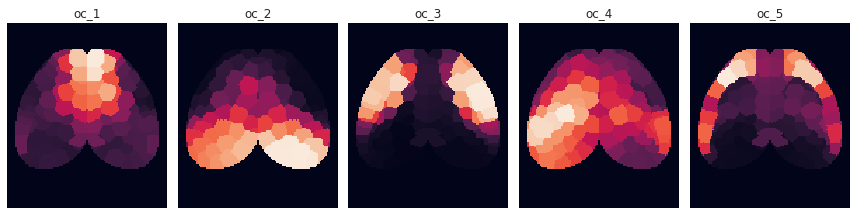

In [43]:
fig, axes = create_figure(1, k, (13.5, 4) if k == 7 else (12, 6))
gam_arr = svinet.pi2arr(result['pi'], cortex_only=True)
for ax, idx in zip(axes.ravel(), range(1, k + 1)):
    im = ax.imshow(gam_arr[idx], cmap='rocket', vmin=0)
    ax.set_title(f"oc_{idx}")
remove_ticks(axes)
plt.show()

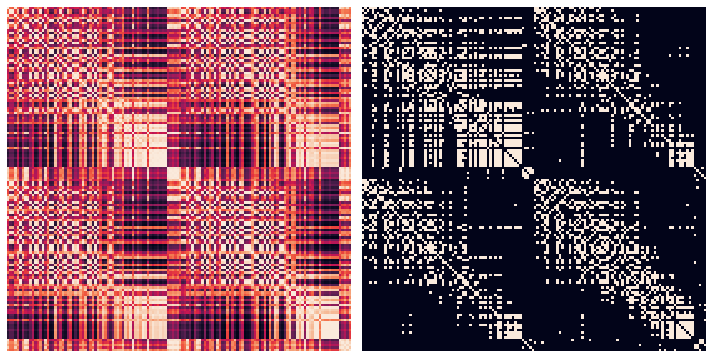

In [44]:
fig, axes = create_figure(1, 2, (10, 7))
d = sp_dist.pdist(result['pi'].T, metric='cosine')
d = sp_dist.squareform(d)
im = axes[0].imshow(dist2sim(d))

axes[1].imshow(svinet.adjacencies[20].astype(bool))
remove_ticks(axes)
plt.show()

In [189]:
hamil = {
    k: nx.normalized_laplacian_matrix(g, weight='weight').toarray()
    for k, g in svinet.graphs.items()
}

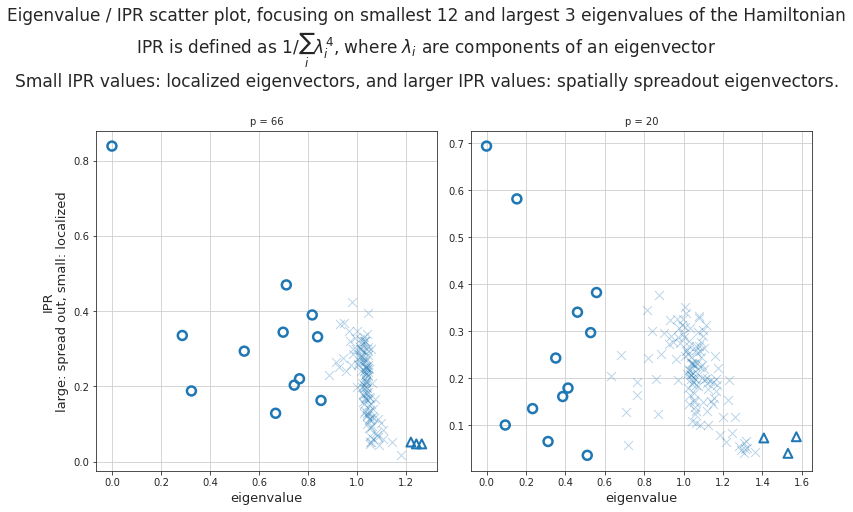

In [191]:
# HIDE CODE


num_top = 12
num_bot = 3

sns.set_style('whitegrid')
nrows = 1
ncols = int(np.ceil(len(hamil) / nrows))
fig, axes = create_figure(nrows, ncols, (11, 7), 'ticks', reshape=True)

for idx, (_p, h) in enumerate(hamil.items()):
    i = idx // ncols
    j = idx % ncols
    
    w, v = np.linalg.eigh(h)
    ipr = 1 / np.power(v, 4).sum(0)
    ipr /= len(ipr)

    sorted_indxs = np.argsort(w)[::-1]

    axes[i, j].scatter(
        x=w[sorted_indxs[num_bot:-num_top]],
        y=ipr[sorted_indxs[num_bot:-num_top]],
        color='C0',
        marker='x',
        s=80,
        lw=1.,
        alpha=0.3,
    )
    axes[i, j].scatter(
        x=w[sorted_indxs[:num_bot]],
        y=ipr[sorted_indxs[:num_bot]],
        color='none',
        edgecolors='C0',
        marker='^',
        s=80,
        lw=2,
    )
    axes[i, j].scatter(
        x=w[sorted_indxs[-num_top:]],
        y=ipr[sorted_indxs[-num_top:]],
        color='none',
        edgecolors='C0',
        s=80,
        lw=2.5,
    )
    axes[i, j].set_title(f"p = {_p}", fontsize=10)
    if i == nrows - 1:
        axes[i, j].set_xlabel('eigenvalue', fontsize=13)
    if j == 0:
        axes[i, j].set_ylabel('IPR\nlarge: spread out, small: localized', fontsize=13)
    axes[i, j].grid()    
    

msg = 'Eigenvalue / IPR scatter plot, focusing on smallest {:d} and largest {:d} eigenvalues of the Hamiltonian\n'
msg += r"IPR is defined as $1 / \sum_i \lambda_i^4$, where $\lambda_i$ are components of an eigenvector"
msg += '\nSmall IPR values: localized eigenvectors, and larger IPR values: spatially spreadout eigenvectors.'
fig.suptitle(msg.format(num_top, num_bot), fontsize=17, y=1.01)
plt.show()

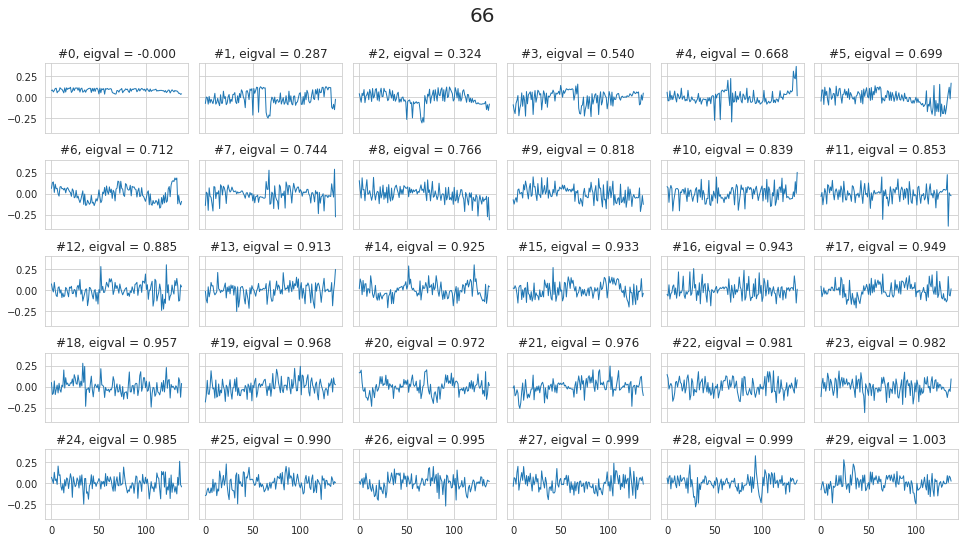

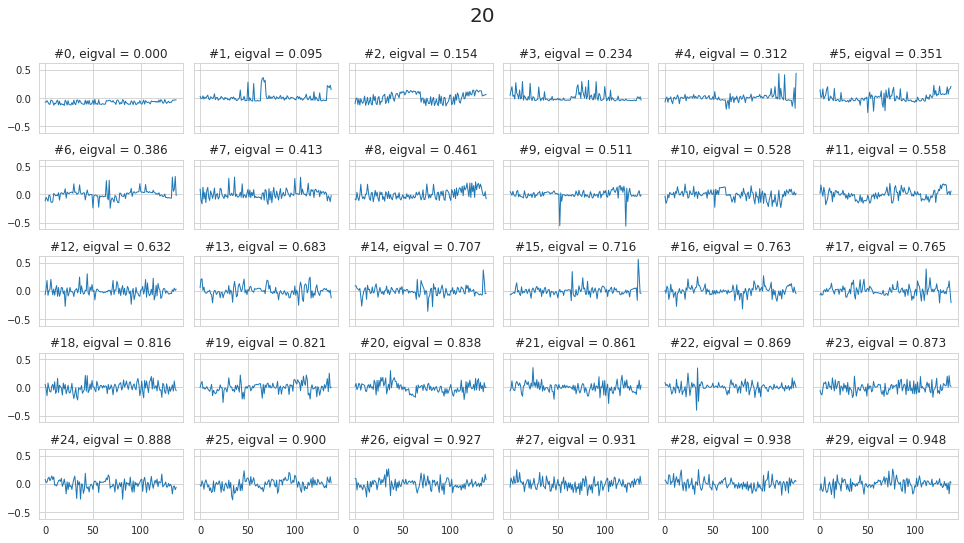

In [49]:
sns.set_style('whitegrid')
nrows, ncols = 5, 6

for _p, h in hamil.items():
    w, v = np.linalg.eigh(h)
    sort_idxs = np.argsort(w)#[::-1]

    fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 1.5 * nrows), sharex='all', sharey='all')
    for idx in range(nrows*ncols):
        i, j = idx//ncols, idx%ncols 
            # sort_abs_idxs = np.argsort(np.abs(w))
        axes[i, j].plot(v[:, sort_idxs[idx]], color='C0', label=k, lw=1)
        axes[i, j].set_title('#{:d}, eigval = {:.3f}'.format(idx, w[sort_idxs[idx]]))

    fig.suptitle(_p, fontsize=20, y=1.)
    fig.tight_layout()
    plt.show()

## IPR combined

In [192]:
hamil = collections.defaultdict(dict)
for key, sv in result['svinet_all'].items():
    hamil['full'][key] = nx.normalized_laplacian_matrix(
        sv.graphs[sv.percentiles[0]], weight='weight').toarray()
    hamil[20][key] = nx.normalized_laplacian_matrix(
        sv.graphs[20], weight='weight').toarray()
hamil = dict(hamil)

In [193]:
list(hamil)

['full', 20]

In [340]:
_h = [np.expand_dims(h, axis=0) for h in hamil[20].values()]
_h = np.concatenate(_h)
w, v = np.linalg.eigh(_h)
ipr = np.power(v, 4).sum(1)
ipr = np.power(ipr, -1)
ipr /= ipr.shape[-1]

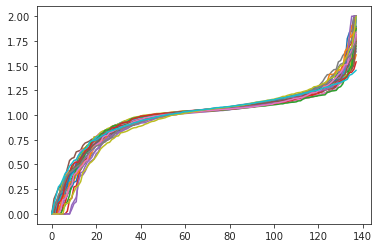

In [341]:
plt.plot(w.T);

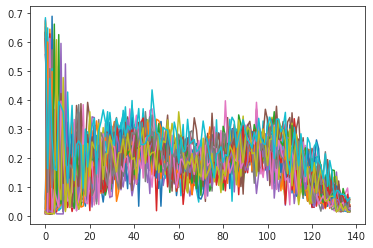

In [342]:
plt.plot(ipr.T);

<AxesSubplot:>

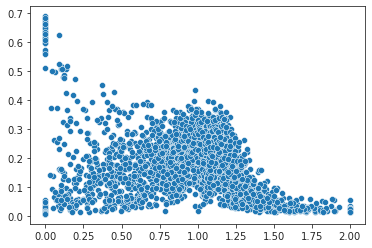

In [331]:
sns.scatterplot(x=w.ravel(), y=ipr.ravel())

<AxesSubplot:>

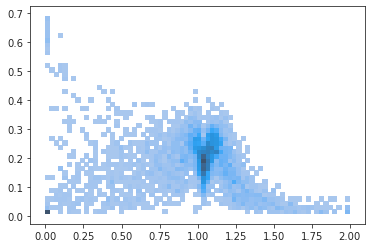

In [332]:
sns.histplot(x=w.ravel(), y=ipr.ravel())

<AxesSubplot:>

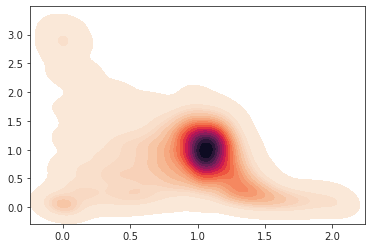

In [218]:
sns.kdeplot(
    x=w.ravel(),
    y=ipr.ravel(),
    fill=True,
    levels=20, 
    cmap='rocket_r',
    thresh=0.001,
)

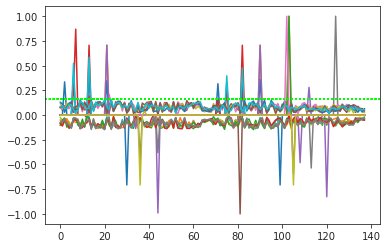

In [335]:
bad = {}
for i in range(30):
    plt.plot(v[i, :, 0])
    plt.axhline(0.16, color='lime', ls=':')
    if max(abs(v[i, :, 0])) > 0.16:
        bad[list(result['svinet_all'])[i]] = i
plt.show()

In [336]:
bad

{
    'sub-SLC01_ses-1': 0,
    'sub-SLC01_ses-2': 1,
    'sub-SLC02_ses-1': 3,
    'sub-SLC02_ses-2': 4,
    'sub-SLC02_ses-3': 5,
    'sub-SLC03_ses-1': 6,
    'sub-SLC03_ses-2': 7,
    'sub-SLC04_ses-2': 10,
    'sub-SLC05_ses-2': 13,
    'sub-SLC05_ses-3': 14,
    'sub-SLC06_ses-3': 17,
    'sub-SLC07_ses-2': 19,
    'sub-SLC08_ses-1': 21,
    'sub-SLC08_ses-2': 22,
    'sub-SLC09_ses-1': 24,
    'sub-SLC09_ses-3': 26,
    'sub-SLC10_ses-2': 28
}

<AxesSubplot:>

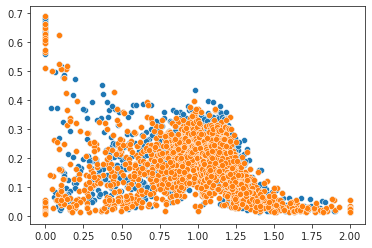

In [337]:
sns.scatterplot(x=w.ravel(), y=ipr.ravel())
sns.scatterplot(x=w[list(bad.values())].ravel(), y=ipr[list(bad.values())].ravel())

<AxesSubplot:>

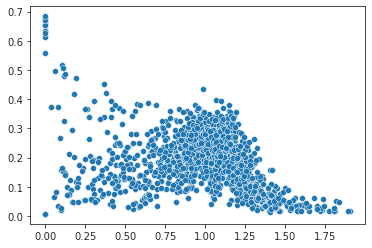

In [338]:
good = np.delete(range(30), list(bad.values()))
sns.scatterplot(x=w[good].ravel(), y=ipr[good].ravel())

<AxesSubplot:>

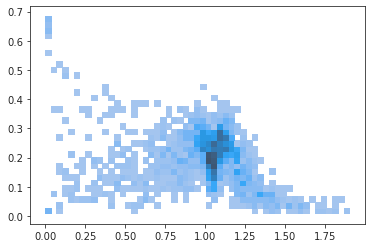

In [339]:
sns.histplot(x=w[good].ravel(), y=ipr[good].ravel())

In [ ]:
# HIDE CODE


num_top = 12
num_bot = 3

sns.set_style('whitegrid')
nrows = 1
ncols = int(np.ceil(len(hamil) / nrows))
fig, axes = create_figure(nrows, ncols, (11, 7), 'ticks', reshape=True)

for idx, (_p, h) in enumerate(hamil.items()):
    i = idx // ncols
    j = idx % ncols
    
    w, v = np.linalg.eigh(h)
    ipr = 1 / np.power(v, 4).sum(0)
    ipr /= len(ipr)

    sorted_indxs = np.argsort(w)[::-1]

    axes[i, j].scatter(
        x=w[sorted_indxs[num_bot:-num_top]],
        y=ipr[sorted_indxs[num_bot:-num_top]],
        color='C0',
        marker='x',
        s=80,
        lw=1.,
        alpha=0.3,
    )
    axes[i, j].scatter(
        x=w[sorted_indxs[:num_bot]],
        y=ipr[sorted_indxs[:num_bot]],
        color='none',
        edgecolors='C0',
        marker='^',
        s=80,
        lw=2,
    )
    axes[i, j].scatter(
        x=w[sorted_indxs[-num_top:]],
        y=ipr[sorted_indxs[-num_top:]],
        color='none',
        edgecolors='C0',
        s=80,
        lw=2.5,
    )
    axes[i, j].set_title(f"p = {_p}", fontsize=10)
    if i == nrows - 1:
        axes[i, j].set_xlabel('eigenvalue', fontsize=13)
    if j == 0:
        axes[i, j].set_ylabel('IPR', fontsize=13)
    axes[i, j].grid()    
    

msg = 'Eigenvalue / IPR scatter plot, focusing on smallest {:d} and largest {:d} eigenvalues of the Hamiltonian\n'
msg += r"IPR is defined as $1 / \sum_i \lambda_i^4$, where $\lambda_i$ are components of an eigenvector"
msg += '\nSmall IPR values: localized eigenvectors, and larger IPR values: spatially spreadout eigenvectors.'
fig.suptitle(msg.format(num_top, num_bot), fontsize=17, y=1.01)
plt.show()